<a href="https://colab.research.google.com/github/egorssed/Lensed-source-modelling/blob/Radial-profile-cut/Dataset_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.special as sc
import copy

drive.mount('/content/drive')
Folder='/content/drive/My Drive/Lensed Source modelling'

import sys
sys.path.append(Folder+'/Modules')
import Image_Stats
import Visualization

Mounted at /content/drive


# Preprocessing

In [ ]:
'''def merge_files(split_array):
  images=np.load(Folder+'/Data/Radial_cut_correct/Splitted_data/Images_{}_{}.npy'.format(split_array[0][0],split_array[0][1]))
  labels=pd.read_csv(Folder+'/Data/Radial_cut_correct/Splitted_data/Labels_{}_{}.csv'.format(split_array[0][0],split_array[0][1]),index_col=0)
  for i,split in enumerate(split_array[1:]):
    start,stop=split
    images_t=np.load(Folder+'/Data/Radial_cut_correct/Splitted_data/Images_{}_{}.npy'.format(start,stop))
    labels_t=pd.read_csv(Folder+'/Data/Radial_cut_correct/Splitted_data/Labels_{}_{}.csv'.format(start,stop),index_col=0)

    images=np.append(images,images_t,axis=0)
    labels=labels.append(labels_t)

  return images,labels'''

In [ ]:
'''split_array=[(0,5000),(5000,10000),(10000,15000),(15000,20000),(20000,25000),(25000,30000),(30000,35000),(35000,40000),(40000,45000),(45000,50932)]

galaxies,df=merge_files(split_array)

df.to_csv(Folder+'/Data/Radial_cut_correct/Labels_0_50932.csv')
np.save(Folder+'/Data/Radial_cut_correct/Images_0_50932.npy',galaxies)'''

In [ ]:
'''galaxies=np.load(Folder+'/Data/Radial_cut_correct/Images_0_50932.npy')
df=pd.read_csv(Folder+'/Data/Radial_cut_correct/Labels_0_50932.csv',index_col=0)

def Scaling_factor(series):
  size=np.minimum(series['Original_x_size'],series['Original_y_size'])
  R_cut=series['Original_R_cut']
  if size<2*R_cut:
    return 64/size
  else:
    return np.minimum(64/(2*R_cut),1)

def get_R_cut(series):
  Radial_profile=Image_Stats.Radial_profile(galaxies[series.name],series.Sersic_q,series.Sersic_x0,series.Sersic_y0,series.Sersic_phi,False)
  Radial_profile=Radial_profile-Radial_profile[-1]
  Radial_profile/=np.nanmax(Radial_profile)
  R_cut=np.where((Radial_profile<0.01))[0][0]
  return R_cut

                  

print(galaxies.shape)
print(df.shape)
#galaxies[galaxies<0]=0
df['SNR']=(df['max_I'])/df['Noise_std']
df['SNR_COSMOS']=df['max_I']/df['COSMOS_noise'].apply(np.sqrt)
Scaling_factor=df.apply(Scaling_factor,axis=1)
df['COSMOS_Bulge_HLR']*=Scaling_factor
df['COSMOS_Disk_HLR']*=Scaling_factor
df['COSMOS_Sersic_HLR']*=Scaling_factor
df['COSMOS_R_cut']=np.power(sc.gammaincinv(2*df['COSMOS_Sersic_n'],0.95)/(2*df['COSMOS_Sersic_n']-0.324),df['COSMOS_Sersic_n'])*df['COSMOS_Sersic_HLR']


nonunifomity=np.zeros(len(galaxies))

for i,image in enumerate(galaxies):
    image=copy.deepcopy(image)
    image[image<0]=0
    nonunifomity[i]=image.max()/image.mean()


df['NonUniformity']=nonunifomity

#df['SNR_Power']=/np.power(df['Noise_std'],2)
df=df.reset_index().rename(columns={'index':'COSMOS_index'})
df=df[np.logical_not(np.isnan(df.Sersic_HLR))]

tqdm.pandas()
df['R_cut']=df.progress_apply(get_R_cut,axis=1)

df.to_csv(Folder+'/Data/Radial_cut_correct/Labels_0_50932_processed.csv')'''

(50931, 64, 64)
(50931, 48)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 50930/50930 [1:07:04<00:00, 12.66it/s]


# Dataset

In [ ]:
galaxies=np.load(Folder+'/Data/Radial_cut_correct/Images_0_50932.npy')
df=pd.read_csv(Folder+'/Data/Radial_cut_correct/Labels_0_50932_processed.csv',index_col=0)


Sersic_columns=['Sersic_I','Sersic_HLR','Sersic_n','Sersic_q',
                'Sersic_x0','Sersic_y0','Sersic_phi']
                
COSMOS_Sersic_columns=['COSMOS_Sersic_I','COSMOS_Sersic_HLR','COSMOS_Sersic_n','COSMOS_Sersic_q',
                'COSMOS_Sersic_x0','COSMOS_Sersic_y0','COSMOS_Sersic_phi']

df['PSNR']=20*np.log10(df['max_I']/df['Noise_std'])
df['log_NU']=10*np.log10(df['NonUniformity'])

# Functions

In [ ]:
def Show_stats(images,df,column,min_value,max_value,dimensions=2,invert_colors=False,cut_negatives=False,log_hist=False):
    #Convenient function to observe impact of feature on image
    #For a given limited feature shows histogram of this feature, best and worst galaxy images
    fig=plt.figure(figsize=(20,5))
    plt.subplot(131)

    #Extract galaxies according to feature limits
    df_filt=df[(df[column].values>=min_value) & (df[column].values<=max_value)]
    min_mask=df_filt[column]==df_filt[column].min()
    max_mask=df_filt[column]==df_filt[column].max()
    plt.hist(df_filt[column],bins=100)
    if log_hist:
      plt.xscale('log')
      plt.yscale('log')
    plt.title(column+' histogram')
    
    #Number of galaxies left for given limits
    print(df_filt.shape[0], 'Galaxies')
    print((column + ' [{:.2f},{:.2f}]').format(min_value,max_value))
    
    if dimensions==2:
      #Images of best and worst galaxies in terms of the given feature
      i=(df_filt[min_mask].index)[0]
      image=galaxies[i]
      plt.subplot(132)
      plt.title(column+'={:.2f}'.format(df_filt[column].min()))
      if invert_colors:
        plt.imshow(1-image,cmap='gray_r')
      else:
        plt.imshow(image,cmap='gray_r')
      plt.axis('off')
    
      i=(df_filt[max_mask].index)[0]
      image=galaxies[i]
      plt.subplot(133)
      plt.title(column+'={:.2f}'.format(df_filt[column].max()))
      if invert_colors:
        plt.imshow(1-image,cmap='gray_r')
      else:
        plt.imshow(image,cmap='gray_r')
      plt.axis('off')

      plt.tight_layout()
    elif dimensions==3:
      X = np.arange(-32, 32, 1)
      Y = np.arange(-32, 32, 1)
      X, Y = np.meshgrid(X, Y)

      i=(df_filt[min_mask].index)[0]
      image=copy.deepcopy(galaxies[i])
      if cut_negatives:
          #noise=df.iloc[i]['Noise_mean']
          #image-=noise
          image[image<0]=0
      ax = fig.add_subplot(132, projection='3d')
      ax.plot_surface(X, Y, image/image.max(), cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
      ax.set_title(column+'={:.2f}'.format(df_filt[column].min()))
      ax.set_xticks([])
      ax.set_yticks([])

      i=(df_filt[max_mask].index)[0]
      image=copy.deepcopy(galaxies[i])
      if cut_negatives:
          #noise=df.iloc[i]['Noise_mean']
          #image-=noise
          image[image<0]=0
      ax = fig.add_subplot(133, projection='3d')
      ax.plot_surface(X, Y, image/image.max(), cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
      ax.set_title(column+'={:.2f}'.format(df_filt[column].max()))
      ax.set_xticks([])
      ax.set_yticks([])

    else:
      print('wrong dimensions')

def Show_100(df,invert_colors=False,cut_negatives=False):
    #Show images of 100 first galaxies in the dataframe
    #It is useful if dataframe is sorted in a proper way
    plt.figure(figsize=(20,20))
    gal_to_see=galaxies[df.index[:100].astype(int)]
    for i in range(len(gal_to_see)):
        x=i//10
        y=np.mod(i,10)
        ax = plt.subplot2grid((10,10), (x,y))
        image=copy.deepcopy(gal_to_see[i])
        if cut_negatives:
          #noise=df.iloc[i]['Noise_mean']
          #image-=noise
          image[image<0]=0
        if invert_colors:
          ax.imshow(image,cmap='gray')
        else:
          ax.imshow(image,cmap='gray_r') 
        #,cmap='gray_r'
        ax.axis('off')
    plt.show()

def Show_filtered(df_fit,Column,ascending=True,threshold=0,Index_from=0,invert_colors=False,cut_negatives=False):
  df_filt=df_fit.sort_values(by=[Column],ascending=ascending)
  if ascending:
    df_filt=df_filt[df_filt[Column]>=threshold].iloc[Index_from:]
  else:
    if threshold==0:
      threshold=df_filt[Column].max()
    df_filt=df_filt[df_filt[Column]<=threshold].iloc[Index_from:]
  print(Column,df_filt.iloc[0][Column])
  print('Number of galaxies',len(df_filt))
  Show_100(df_filt,invert_colors,cut_negatives)
  return df_filt

from matplotlib import cm

def present_image(image,Sersic_fit):
  X = np.arange(0, image.shape[0], 1)
  Y = np.arange(0, image.shape[1], 1)
  X, Y = np.meshgrid(X, Y)

  fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
  surf = ax.plot_surface(X, Y, image, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  ax.set_xticks([])
  ax.set_yticks([])

  fig_fit, ax_fit = plt.subplots(subplot_kw={"projection": "3d"})
  xdata=np.vstack((X.ravel(), Y.ravel()))
  surf_fit = ax_fit.plot_surface(X, Y, Sersic_profile(xdata,*Sersic_fit).reshape((64,64)), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
  ax_fit.set_xticks([])
  ax_fit.set_yticks([])

  plt.figure(3)
  plt.imshow(image)
  plt.show()

def Sersic_profile(M,I,HLR,n,q,x0,y0,phi):
    (x, y) = M
    #See Lackner & Gunn 2012 for details on Sersic profile
    k = n*np.exp(0.6950-0.1789/n)
    R=np.sqrt(np.power((x-x0)*np.cos(phi)+(y-y0)*np.sin(phi),2)+
              np.power((y-y0)*np.cos(phi)-(x-x0)*np.sin(phi),2)/np.power(q,2))
    S=I*np.exp(-k*(np.power(R/HLR,1/n)-1))
    return S.ravel()

# Dataset overview

## SNR

32687 Galaxies
PSNR [30.00,100.00]


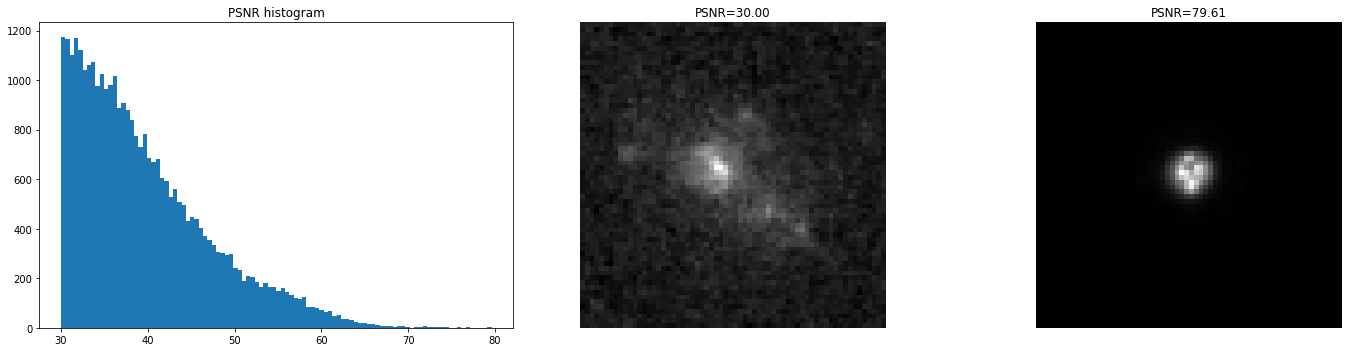

In [ ]:
Show_stats(galaxies,df,'PSNR',30,100,2,True,True,False)

PSNR 57.57205597319501
Number of galaxies 49930


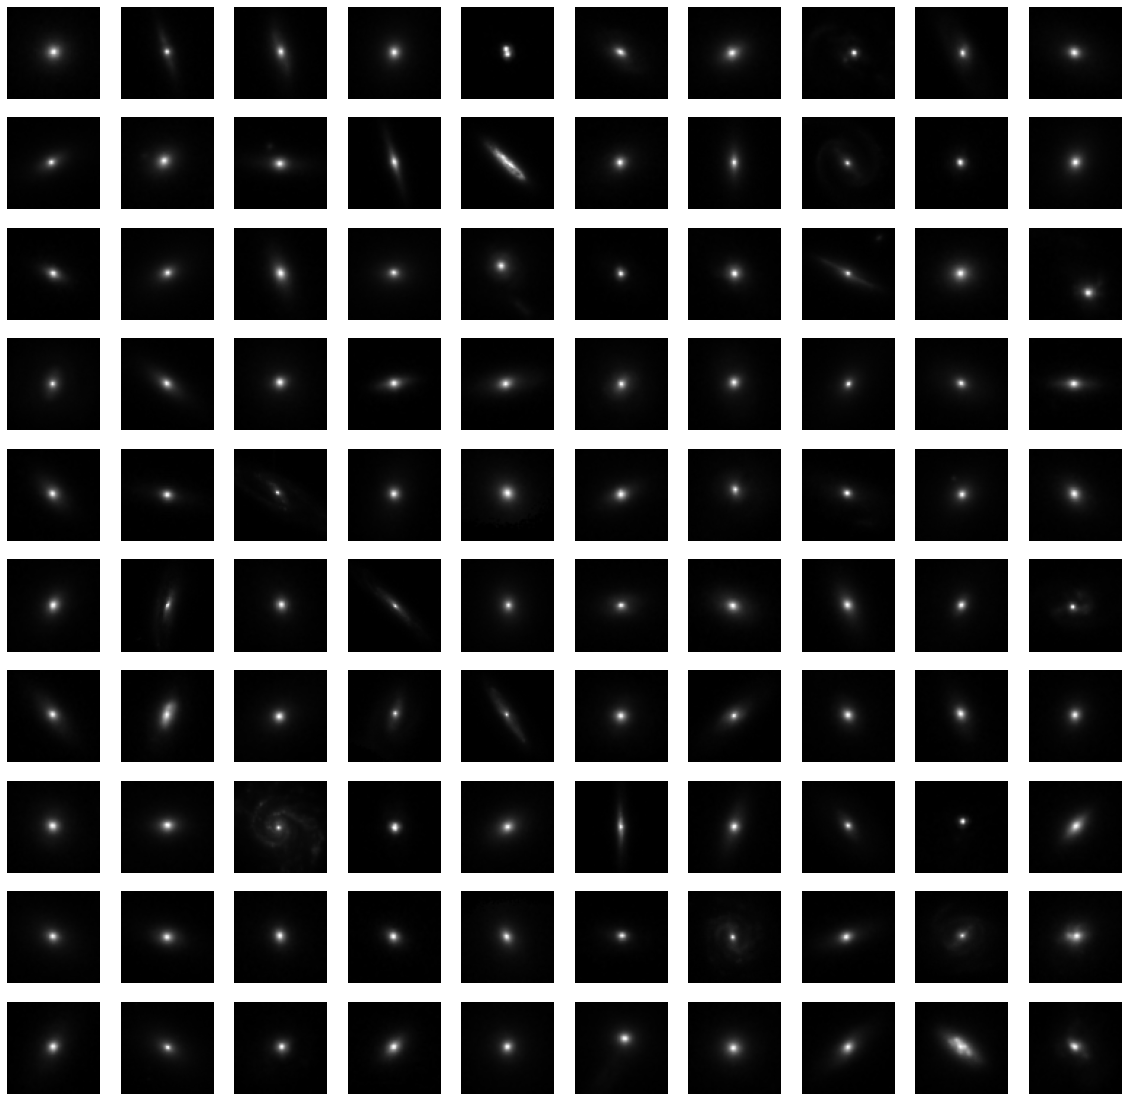

In [ ]:
df_filt=Show_filtered(df,'PSNR',ascending=False,threshold=0,Index_from=1000,invert_colors=True,cut_negatives=True)

## R_cut

Starting from R_cut=22 (~3500 gals) some plausable blobs start appearing

I'd like to perfom a cut from 29

50930 Galaxies
R_cut [0.00,100.00]


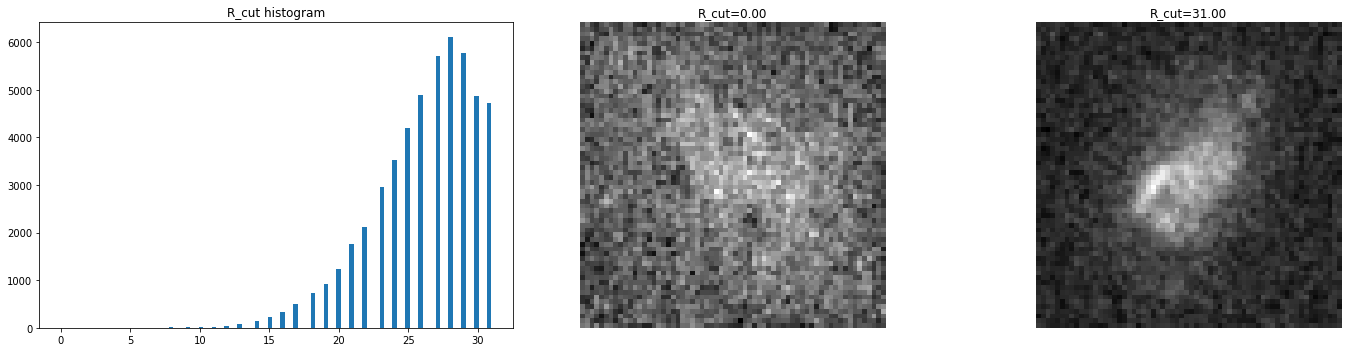

In [ ]:
Show_stats(galaxies,df,'R_cut',0,100,2,True,True,False)

R_cut 21.0
Number of galaxies 6062


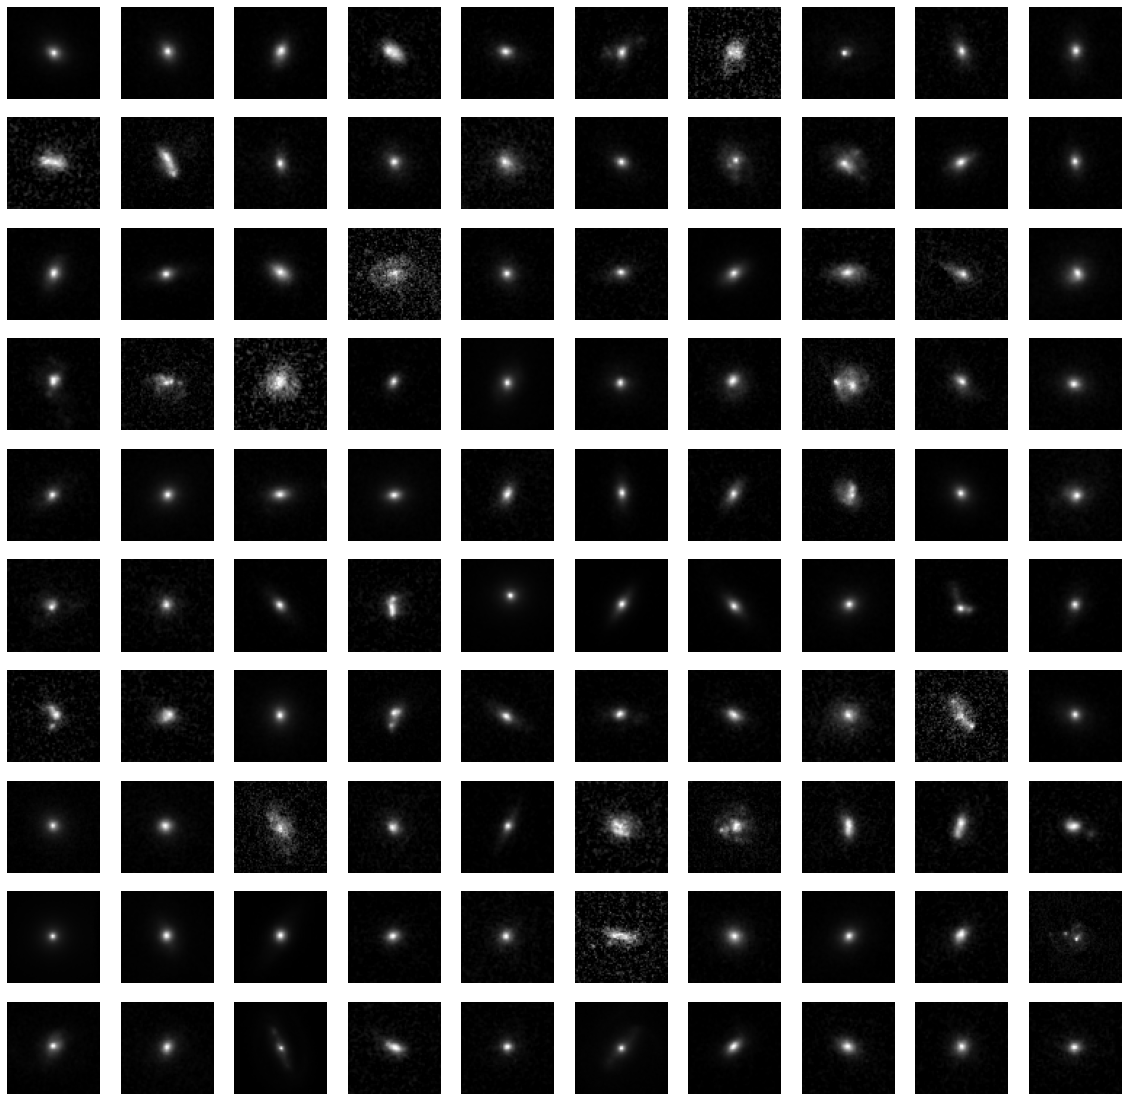

In [ ]:
df_filt=Show_filtered(df,'R_cut',ascending=False,threshold=21,Index_from=0,invert_colors=True,cut_negatives=True)

## Dot-like galaxies

41160 Galaxies
log_NU [10.00,16.00]


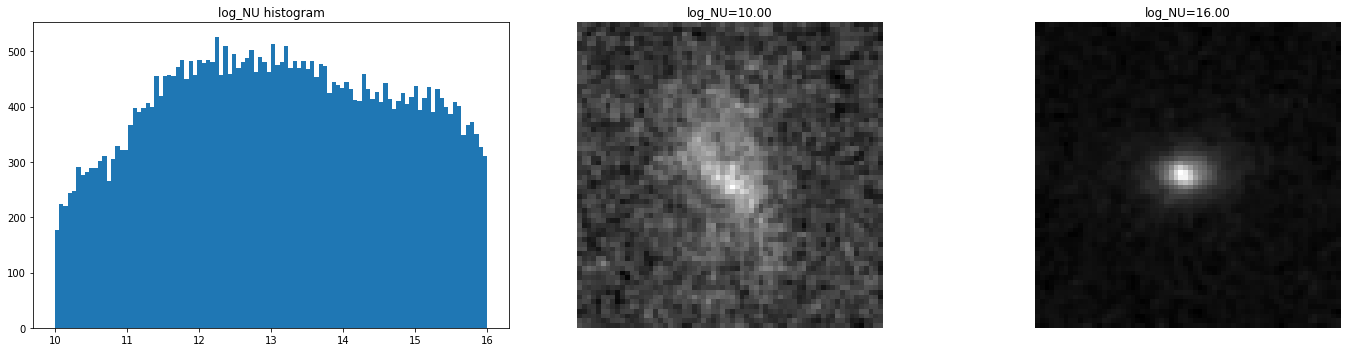

In [ ]:
Show_stats(galaxies,df,'log_NU',10,16,2,True,True,False)

With this filtering we get rid of dot-like galaxies that are all pretty much similar, so they won't add any features to the model rather than bias it towards small galaxies.

12435


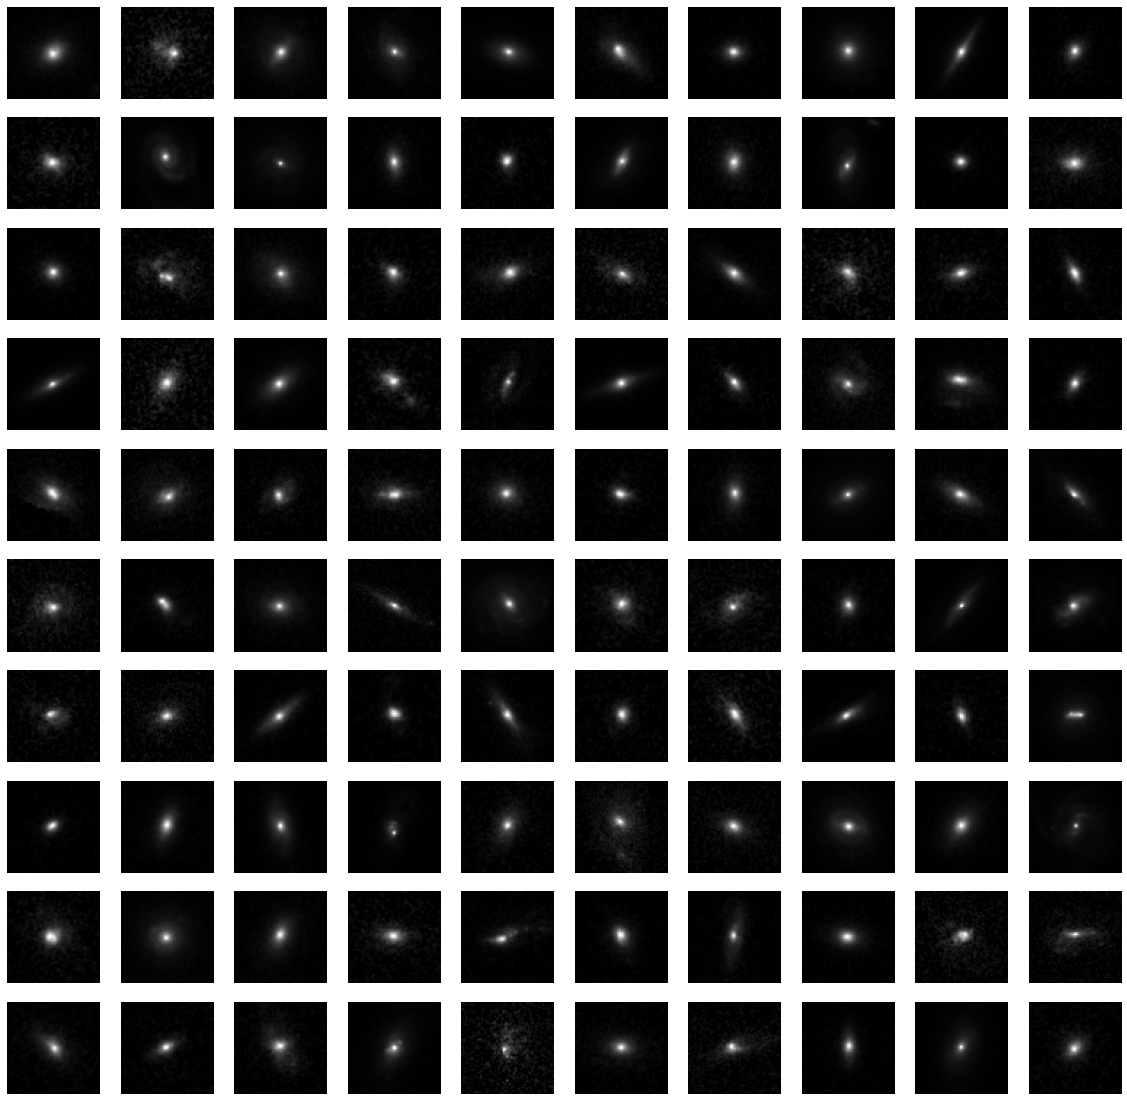

In [ ]:
df_filt=df.sort_values(by=['COSMOS_Sersic_n','Sersic_q'],ascending=[True,True])
df_filt=df_filt[df_filt['COSMOS_Sersic_n']>=2.5]
df_filt=df_filt[df_filt['log_NU']>=13]
print(len(df_filt))
Show_100(df_filt.iloc[100:],True,True)

In [ ]:
'''df_filt=df.sort_values(by=['log_NU','Sersic_q'],ascending=[True,True])
df_filt=df_filt[df_filt['Sersic_q']>=0.75]
df_filt=df_filt[df_filt['log_NU']>=14]
print(len(df_filt))
Show_100(df_filt,True,True)'''

"df_filt=df.sort_values(by=['log_NU','Sersic_q'],ascending=[True,True])\ndf_filt=df_filt[df_filt['Sersic_q']>=0.75]\ndf_filt=df_filt[df_filt['log_NU']>=14]\nprint(len(df_filt))\nShow_100(df_filt,True,True)"

## NonUniformity

log_NU 16.999938591462286
Number of galaxies 48079


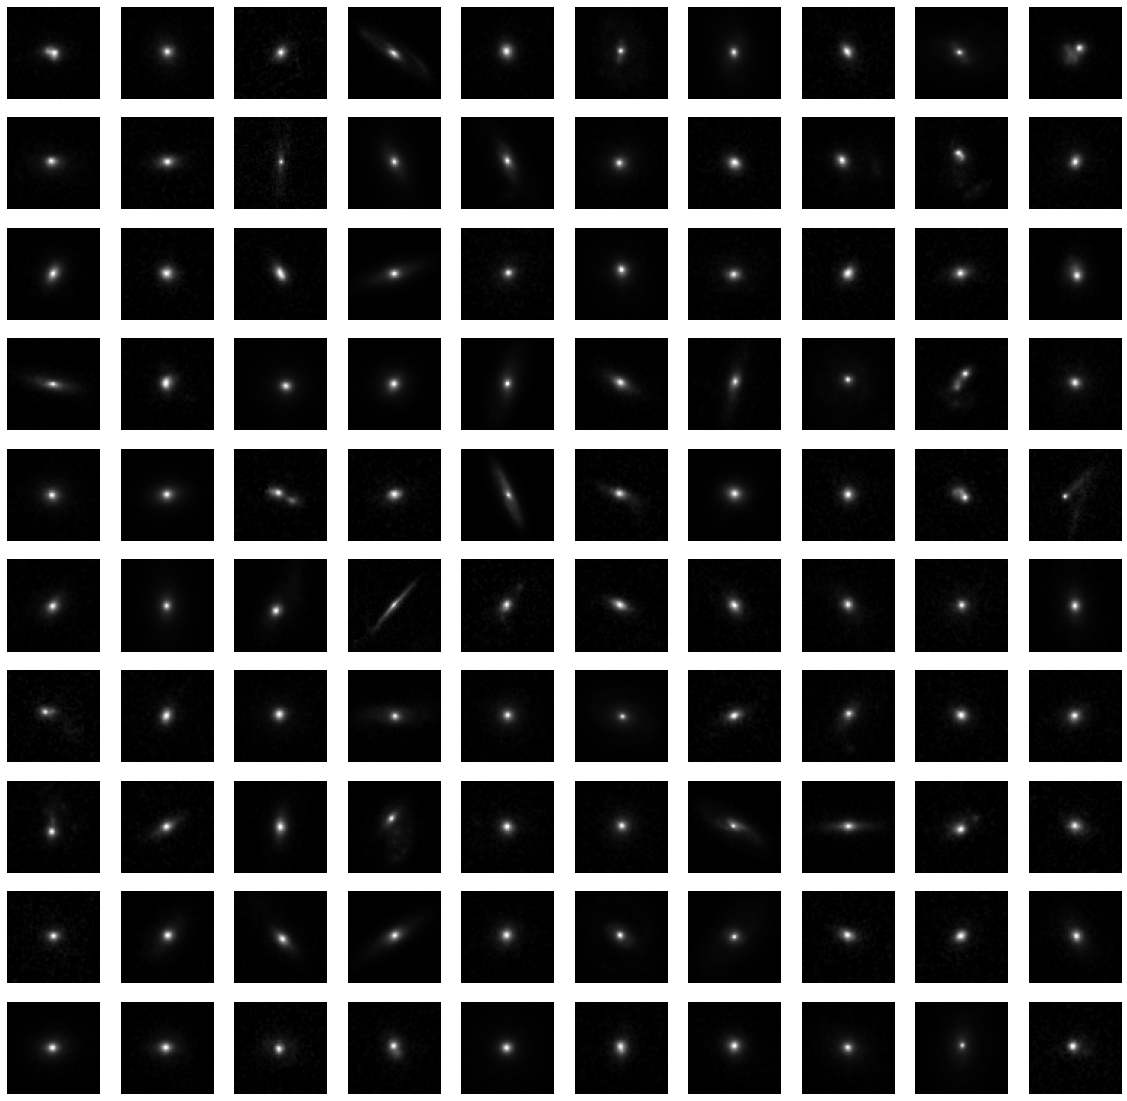

In [ ]:
df_filt=Show_filtered(df,'log_NU',ascending=False,threshold=17,Index_from=0,invert_colors=True,cut_negatives=True)

## Sersic_n

COSMOS_Sersic_n 2.499796289889144
Number of galaxies 38198


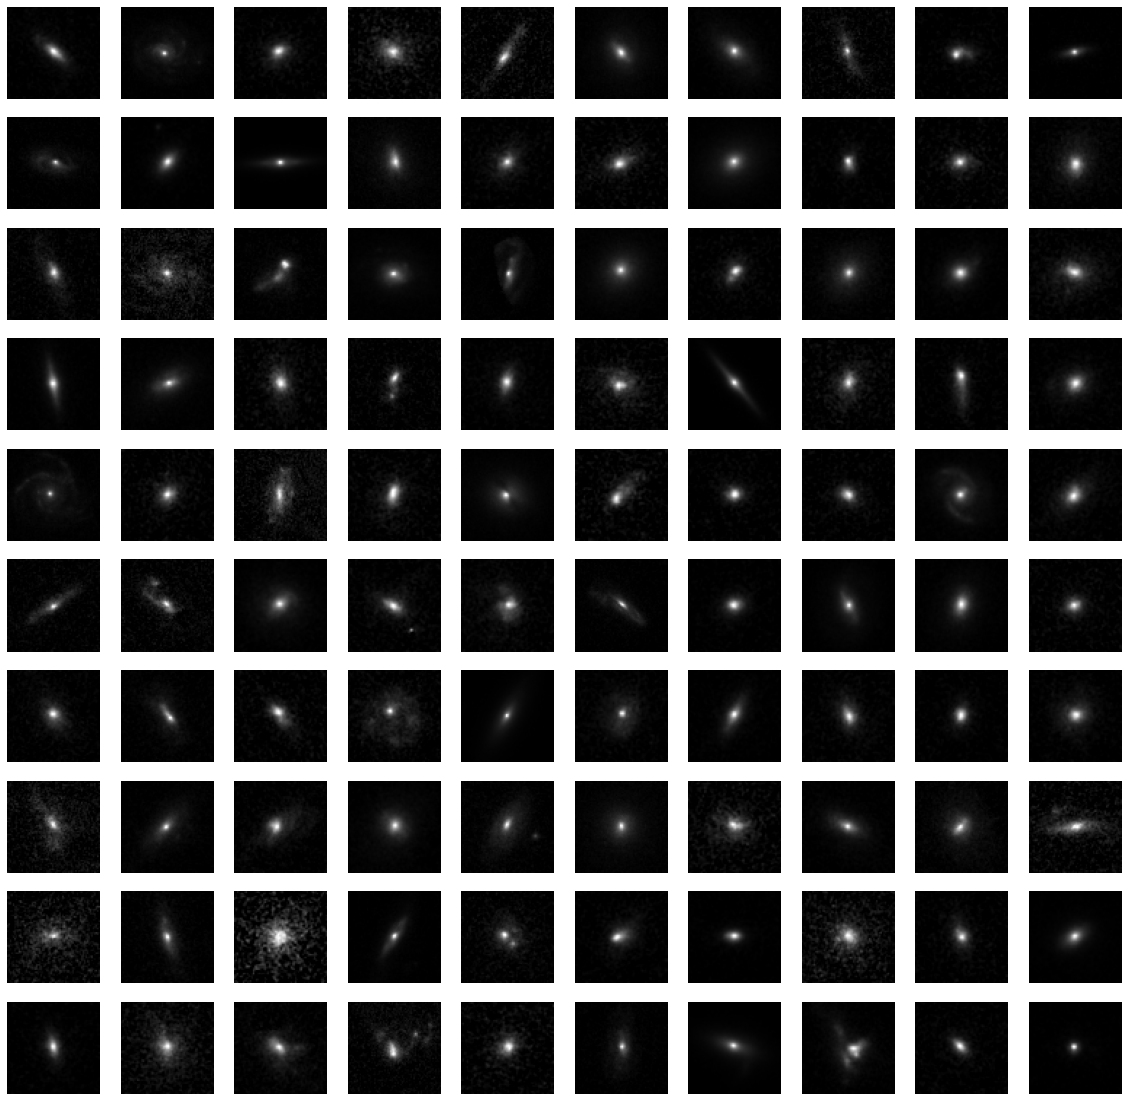

In [ ]:
df_filt=Show_filtered(df,'COSMOS_Sersic_n',ascending=False,threshold=2.5,Index_from=0,invert_colors=True,cut_negatives=True)

# Stats

In [ ]:
#There is no explicit reason to put higher limit on the SNR
mask_SNR=(df.PSNR>30)
#mask_R_cut=(df.R_cut>25)
mask_NU=(df.log_NU<17)
#mask_n=(df.COSMOS_Sersic_n<2.5)

#mask_dot_like=(df.log_NU>=14) & (df.Sersic_q>=0.75)
mask_dot_like=(df.log_NU>=13) & (df.COSMOS_Sersic_n>=2.5) | (df.R_cut<21)

df_filtered=df[mask_SNR & np.logical_not(mask_dot_like) & mask_NU]
#Filtered_galaxies=galaxies[df_filt.index]
#df_filt.reset_index(inplace=True,drop=True)
print(len(df_filtered))

#Filtered_galaxies=galaxies[df_filtered.index]
#Filtered_galaxies[Filtered_galaxies<0]=0
#df_filtered.reset_index(inplace=True,drop=True)

19247


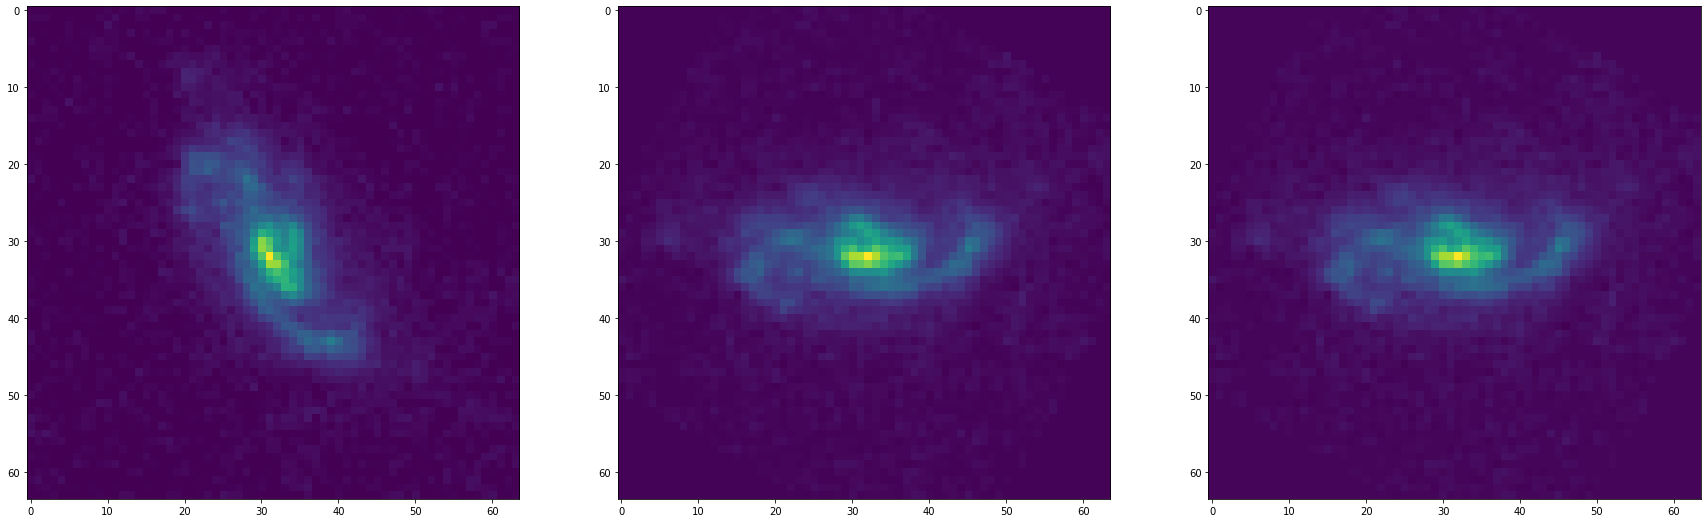

In [ ]:
from scipy.ndimage import rotate


_,ax=plt.subplots(1,3,figsize=(30,10))
ax[0].imshow(Filtered_galaxies[12937])
scipy_rot=rotate(Filtered_galaxies[12937],df_filtered.iloc[12937]['Sersic_phi']*180/np.pi,reshape=False,order=3)
ax[1].imshow(scipy_rot)
scipy_rot=rotate(Filtered_galaxies[12937],df_filtered.iloc[12937]['Sersic_phi']*180/np.pi,reshape=False,order=5)
ax[2].imshow(scipy_rot)

In [ ]:
'''Filtered_Rotated_galaxies=np.zeros_like(Filtered_galaxies)
for i,image in enumerate(Filtered_galaxies):
  Filtered_Rotated_galaxies[i]=rotate(image,df_filtered.iloc[i]['Sersic_phi']*180/np.pi,reshape=False,order=5)'''

In [ ]:
'''df_filtered.to_csv(Folder+'/Data/Radial_cut_correct/Labels_Filtered.csv')
np.save(Folder+'/Data/Radial_cut_correct/Images_Filtered.npy',Filtered_galaxies)
np.save(Folder+'/Data/Radial_cut_correct/Images_Filtered_Rotated.npy',Filtered_Rotated_galaxies)'''

# Overview of Filtered dataset

 Run before reindexing filtered dataset

## SNR

19247 Galaxies
PSNR [0.00,100.00]


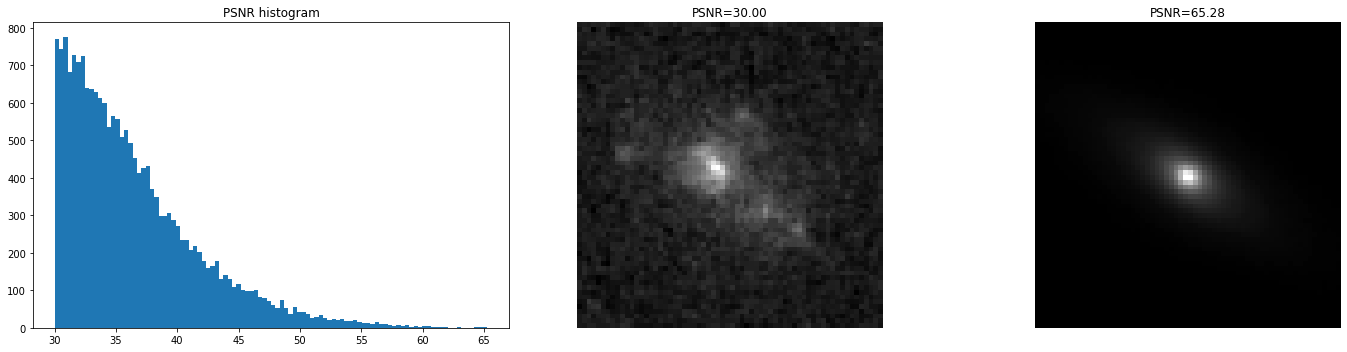

In [ ]:
Show_stats(galaxies,df_filtered,'PSNR',0,100,dimensions=2,invert_colors=True,log_hist=False)

19247 Galaxies
PSNR [0.00,100.00]


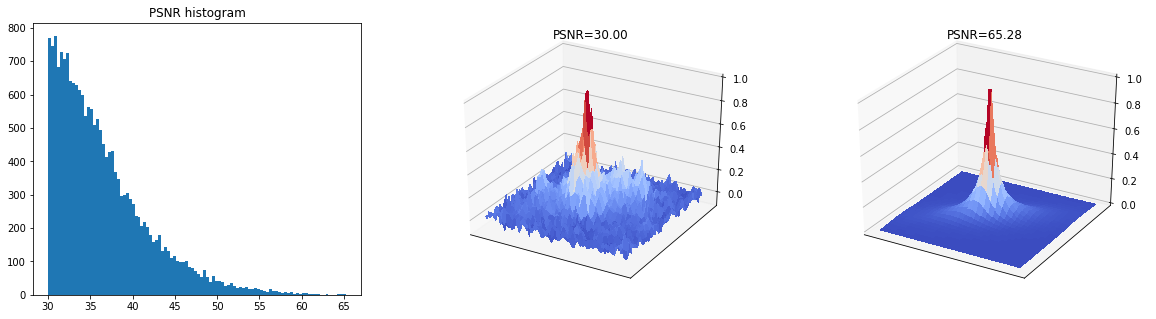

In [ ]:
Show_stats(galaxies,df_filtered,'PSNR',0,100,dimensions=3,invert_colors=True,log_hist=False)

PSNR 30.000173089757524
Number of galaxies 19247


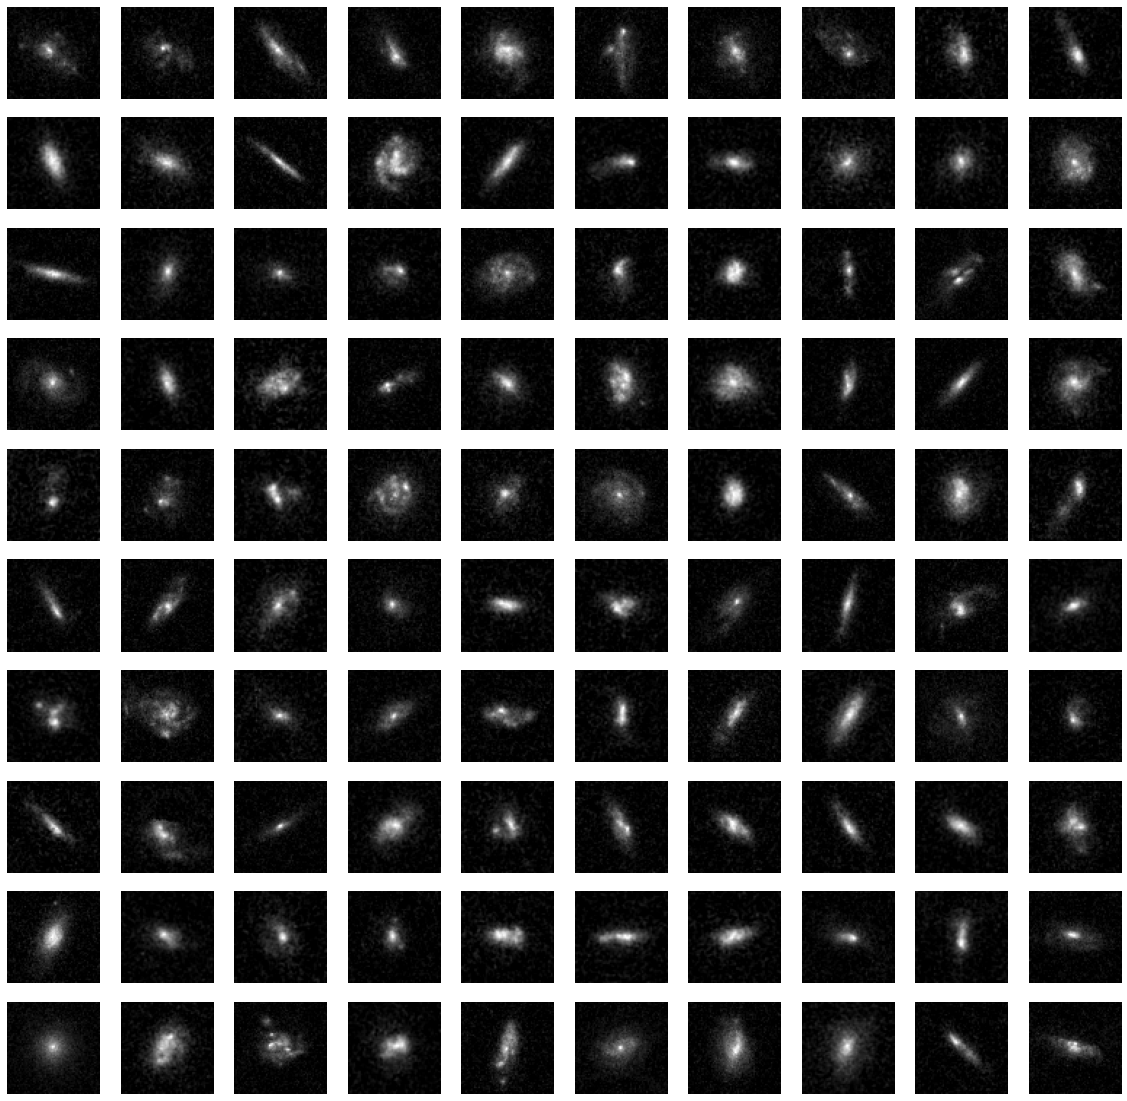

In [ ]:
df_filt=Show_filtered(df_filtered,'PSNR',ascending=True,threshold=0,Index_from=0,invert_colors=True,cut_negatives=True)

## R_cut

19247 Galaxies
R_cut [0.00,100.00]


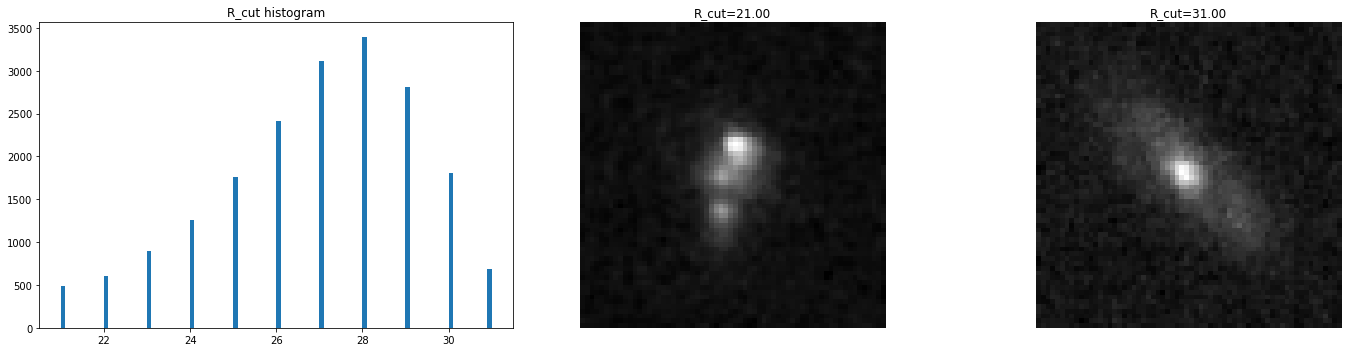

In [ ]:
Show_stats(galaxies,df_filtered,'R_cut',0,100,dimensions=2,invert_colors=True,log_hist=False)

19247 Galaxies
R_cut [0.00,100.00]


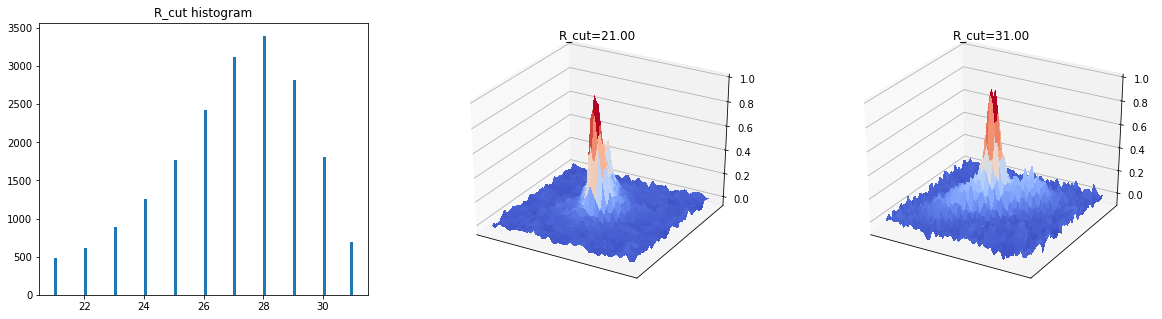

In [ ]:
Show_stats(galaxies,df_filtered,'R_cut',0,100,dimensions=3,invert_colors=True,log_hist=False)

R_cut 21.0
Number of galaxies 19247


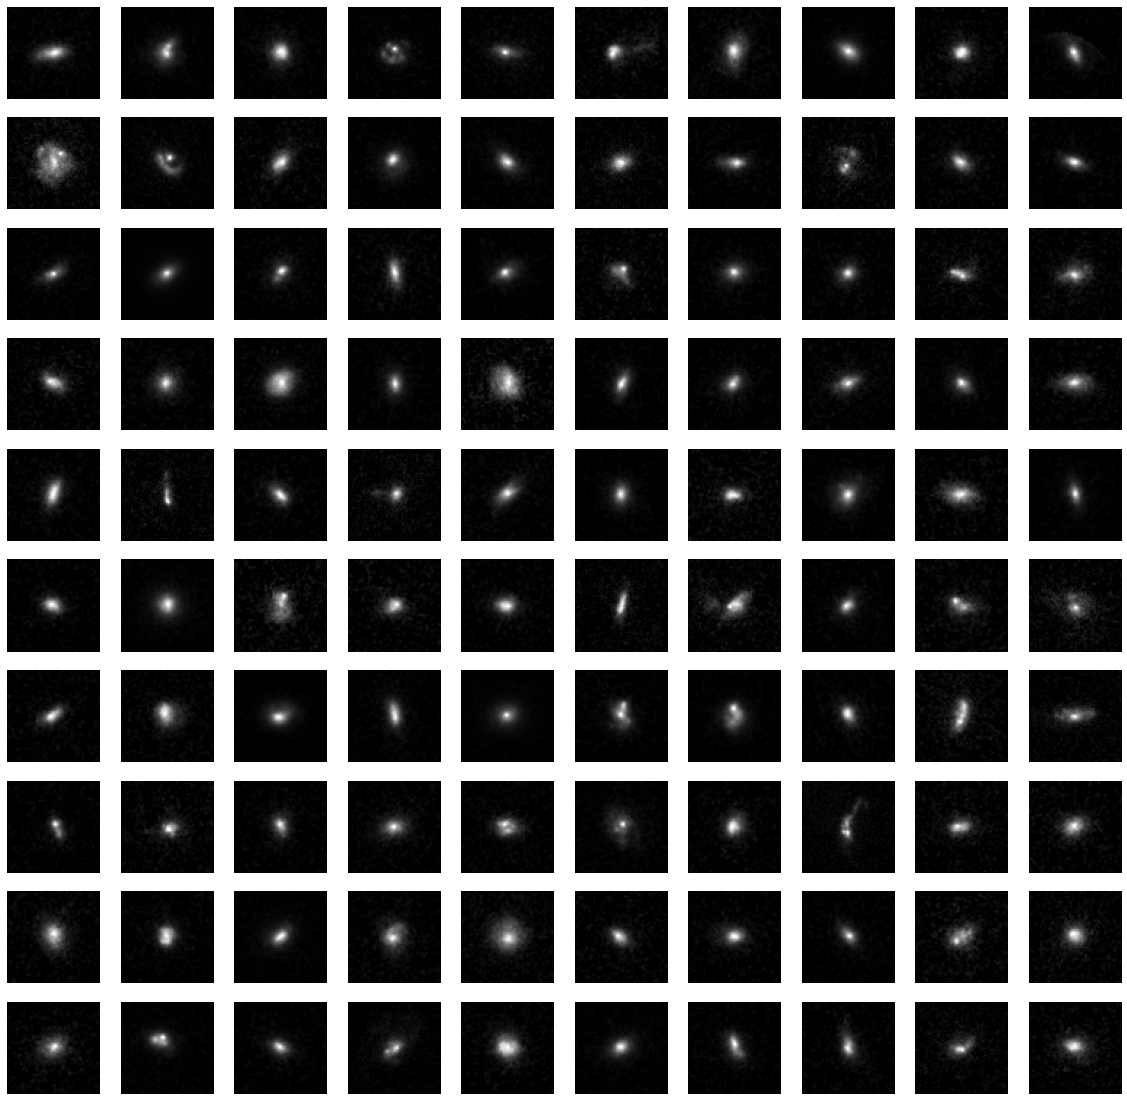

In [ ]:
df_filt=Show_filtered(df_filtered,'R_cut',ascending=True,threshold=0,Index_from=0,invert_colors=True,cut_negatives=True)

## NonUniformity

19247 Galaxies
log_NU [0.00,100.00]


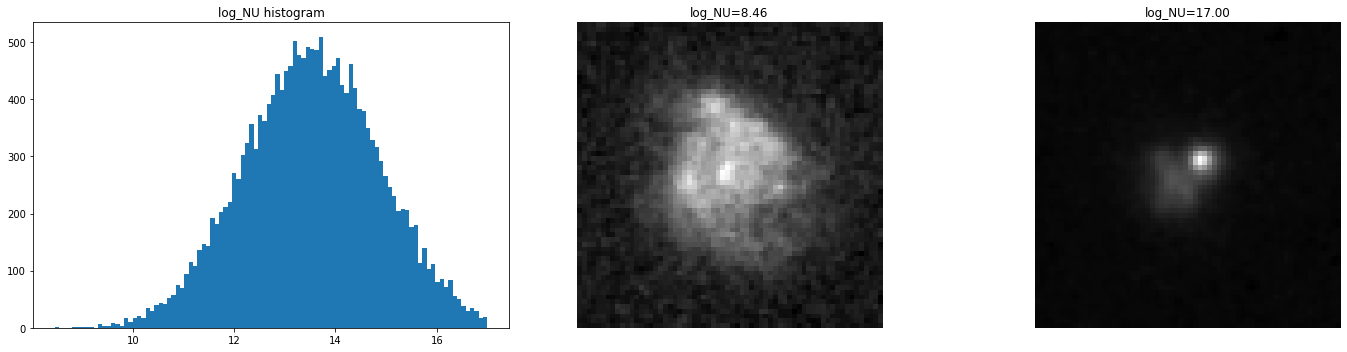

In [ ]:
Show_stats(galaxies,df_filtered,'log_NU',0,100,dimensions=2,invert_colors=True,log_hist=False)

19247 Galaxies
log_NU [0.00,100.00]


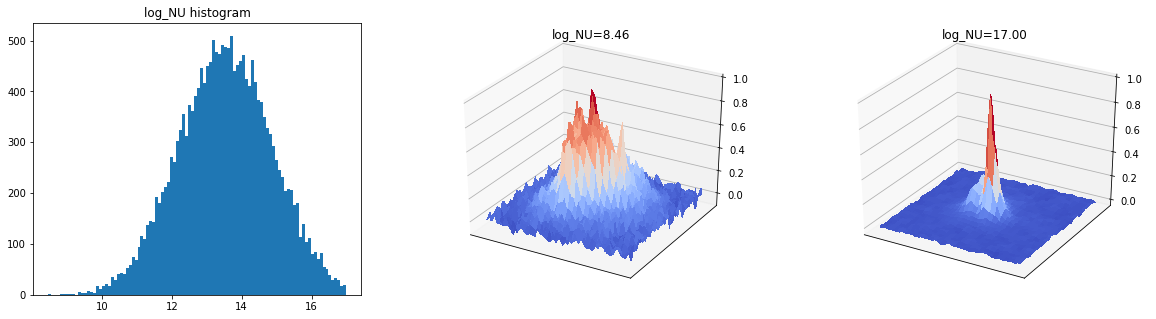

In [ ]:
Show_stats(galaxies,df_filtered,'log_NU',0,100,dimensions=3,invert_colors=True,log_hist=False)

log_NU 16.996209426597872
Number of galaxies 19247


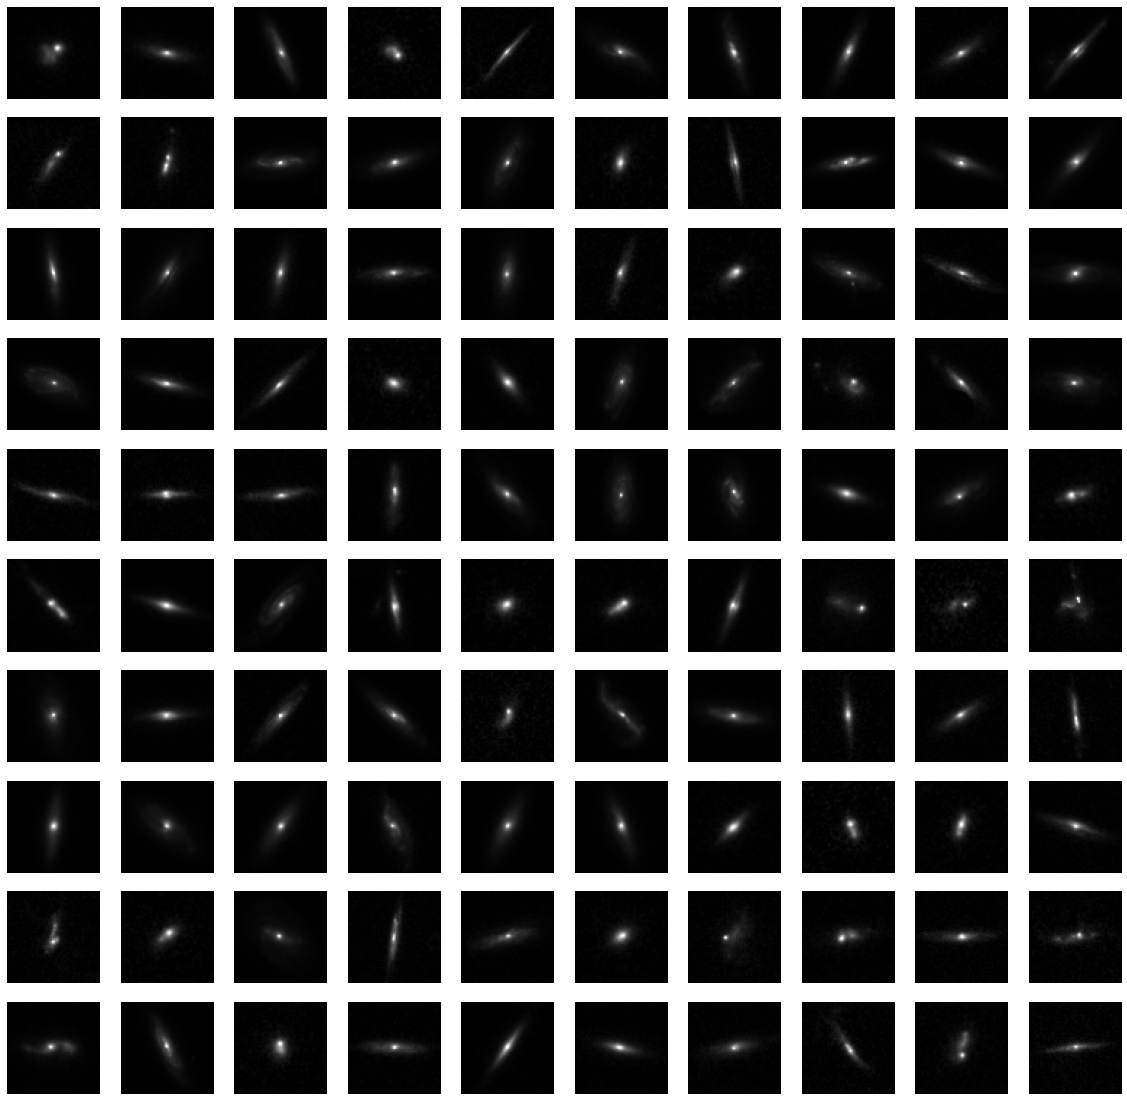

In [ ]:
df_filt=Show_filtered(df_filtered,'log_NU',ascending=False,threshold=0,Index_from=0,invert_colors=True,cut_negatives=True)